# DBSCAN

## Importar librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons # datos de prueba
from sklearn.cluster import DBSCAN  # modelo DBSCAN
from sklearn.metrics import silhouette_score

## Preparando datos de prueba

In [2]:
X, y, c = make_blobs(500, cluster_std=0.8, centers=4, n_features=2,return_centers=True)

df_blobs = pd.DataFrame(
    {
        'x1': X[:,0],
        'x2': X[:,1]
    }
)

df_centers = pd.DataFrame(
    {
        'x1': c[:,0],
        'x2': c[:,1],
    }
)


In [3]:
# datos en forma de media luna

X_m ,y_m = make_moons(n_samples=250, noise=0.05, random_state=42)

df_moons = pd.DataFrame(
    {
        'x1': X_m[:,0],
        'x2': X_m[:,1]
    }
    )

## Visualización de datos

Visualizamos los datos de df_blobs

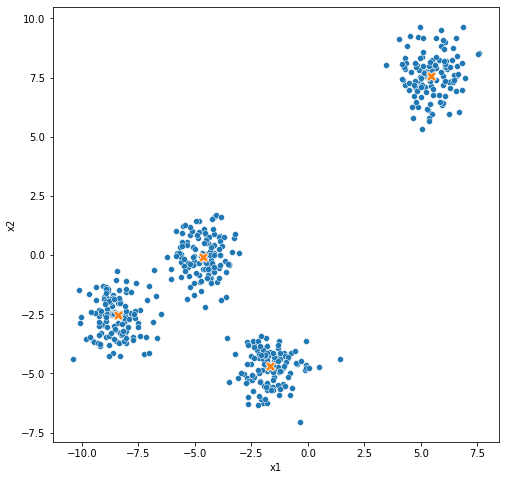

In [4]:
# tamano del grafico
fig = plt.figure(figsize=(8,8))
# grafico de los datos df_blobs
sns.scatterplot(data=df_blobs, x='x1', y='x2')
sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s=100)
plt.plot()
plt.show()

Visualizamos los datos de df_moons

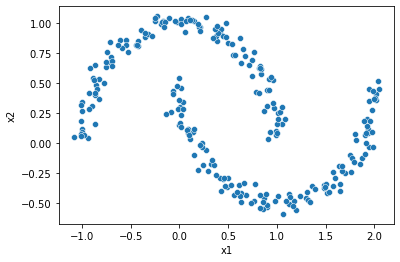

In [5]:
sns.scatterplot(data=df_moons, x='x1', y='x2')
plt.show()

> Aplicar K-Means en estos datos no funciona debido a que no presenta forma esferica

## Implementando DBSCAN

In [6]:
# definimos el modelo con sus respectivos parametros
dbscan_cluster = DBSCAN(eps=0.3, min_samples=3)

# generamos la prediccion con los datos de las medias lunas
y_m_predict = dbscan_cluster.fit_predict(X_m)

# agregamos las predicciones al dataframe d_moons
df_moons['cluster'] = y_m_predict

Visualizamos los datos de la media luna pero esta vez haciendo una segmentacion con la prediccion

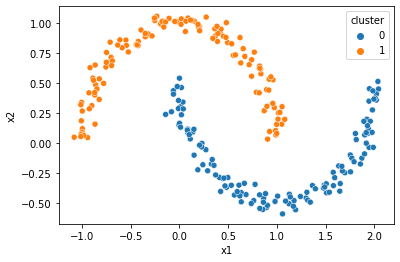

In [7]:
sns.scatterplot(data=df_moons, x='x1', y='x2', hue='cluster')
plt.show()

> El modelo logra separar los dos clusteres de manera correcta. La clave fue la eleccion correcta de los hiperparametros

Vamos a aplicar DBSCAN en los datos de df_blobs para ver como el algoritmo resuelve este tipo de problemas.

## Hyperparameters

## Evaluación de DBSCAN